In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [11]:
learning_rate_anr_capex = 0
learning_rate_h2_capex = 0
csv_path = './results/ammonia_anr_lr_'+str(learning_rate_anr_capex)+'%_h2_lr_'+str(learning_rate_h2_capex)+'%.csv'
clean_save_path = './results/ammonia_anr_lr_'+str(learning_rate_anr_capex)+'%_h2_lr_'+str(learning_rate_h2_capex)+'%_clean.csv'
save_fig_path = './results/ammonia_anr_lr_'+str(learning_rate_anr_capex)+'%_h2_lr_'+str(learning_rate_h2_capex)+'%.png'

In [12]:
df = pd.read_csv(csv_path)
df.sort_values(by=['Breakeven NG price ($/MMBtu)'], inplace=True)
df.reset_index(inplace=True)
df.drop(columns=['index'], inplace=True)


In [13]:
anr_param = pd.read_excel('ANRs.xlsx', sheet_name='FOAK')

### Cumulative number of viable ammonia plants and ANR modules

In [14]:
anr_thermal_power = anr_param[['Power in MWt', 'Reactor']]
df = df.merge(anr_thermal_power, how='inner', left_on=['ANR type'], right_on=['Reactor'])
df.sort_values(by=['Breakeven NG price ($/MMBtu)'], inplace=True)
df['Deployed Power (MWt)'] = df['Power in MWt']*df['# ANR modules']
df['ANR Nameplate Capacity (GWt)'] = df['Deployed Power (MWt)'].cumsum()/1000

In [15]:
df['Viable ANR modules count'] = df['# ANR modules'].cumsum()
df.reset_index(inplace=True)
df.drop(columns=['index'], inplace=True)
df['Viable ANR ammonia plants count'] = df.index+1
df.head(5)

,plant_id,H2 Dem (kg/day),Aux Elec Dem (MWe),Alkaline,HTSE,PEM,ANR type,# ANR modules,Breakeven NG price ($/MMBtu),Ann. CO2 emissions (kgCO2eq/year),...,Ammonia capacity (tNH3/year),Net Rev. ($/year),ANR CRF,Depl. ANR Cap. (MWe),Power in MWt,Reactor,Deployed Power (MWt),ANR Nameplate Capacity (GWt),Viable ANR modules count,Viable ANR ammonia plants count
0,CF_Do,5.441214e+06,53.454909,0,5442.0,0,iMSR,35,23.236802,5.103946e+08,...,3935000.0,-2.825284e+09,0.088827,4935.0,300,iMSR,10500,10.5,35,1
1,Ko_En,1.403515e+06,13.788242,0,1404.0,0,iMSR,9,23.336586,1.316784e+08,...,1015000.0,-7.318795e+08,0.088827,1269.0,300,iMSR,2700,13.2,44,2
2,CF_Ve,1.521051e+06,14.942922,0,1522.0,0,iMSR,10,23.785516,1.427454e+08,...,1100000.0,-8.083895e+08,0.088827,1410.0,300,iMSR,3000,16.2,54,3
3,LS_El,6.153342e+05,6.045091,0,616.0,0,iMSR,4,23.861412,5.777345e+07,...,445000.0,-3.280712e+08,0.088827,564.0,300,iMSR,1200,17.4,58,4
4,Nu_Au,1.057822e+06,10.392123,0,1058.0,0,iMSR,7,23.991273,9.922777e+07,...,765000.0,-5.670494e+08,0.088827,987.0,300,iMSR,2100,19.5,65,5


### Avoided carbon emissions

In [16]:
ammonia_demand_df = pd.read_excel('./h2_demand_ammonia_us_2022.xlsx', sheet_name='processed')
df = df.merge(ammonia_demand_df, on='plant_id')
ratio_co2_to_nh3 = 2.30 # tCO2eq/tNH3
df['NG path GHG (tCO2/year)'] = df.apply(lambda x:x['Capacity (tNH3/year)']*2.30, axis=1)

In [17]:
df['Ann. avoided CO2 emissions (MMT-CO2/year)'] = (df['NG path GHG (tCO2/year)'] - (df['Ann. CO2 emissions (kgCO2eq/year)']/1e3))/1e6
df['Viable avoided emissions (MMT-CO2/year)'] = df['Ann. avoided CO2 emissions (MMT-CO2/year)'].cumsum()

### Save

In [18]:
df_clean = df[["plant_id", 'Capacity (tNH3/year)', 'H2 Dem (kg/day)', 'HTSE', 'ANR type', '# ANR modules', 'Net Rev. ($/year)', 'Ann. avoided CO2 emissions (MMT-CO2/year)', 'Breakeven NG price ($/MMBtu)']]
df_clean.sort_values(by=['Breakeven NG price ($/MMBtu)'], inplace=True)
df_clean['H2 Dem (kg/day)'] /=1e3

df_clean['HTSE'] = df_clean['HTSE'].apply(lambda x: int(x))

df_clean['H2 Dem (kg/day)'] = df_clean['H2 Dem (kg/day)'].apply(lambda x:np.round(x,1))

df_clean['Avoided cost of CO2 ($/ton)'] = df_clean['Net Rev. ($/year)']/(1e6*df_clean['Ann. avoided CO2 emissions (MMT-CO2/year)'])
df_clean['Avoided cost of CO2 ($/ton)'] = df_clean['Avoided cost of CO2 ($/ton)'].apply(lambda x:np.round(np.abs(x),1))

df_clean['Net Rev. ($/year)'] = df_clean['Net Rev. ($/year)'].apply(lambda x: np.round(x/1e6,1))

df_clean['Ann. avoided CO2 emissions (MMT-CO2/year)']= df_clean['Ann. avoided CO2 emissions (MMT-CO2/year)'].apply(lambda x: np.round(x,1))

df_clean['Breakeven NG price ($/MMBtu)'] = df_clean['Breakeven NG price ($/MMBtu)'].apply(lambda x : np.round(x,1))

df_clean.rename(columns={'H2 Dem (kg/day)': 'Demand (MT H2/day)',
                         'Net Rev. ($/year)': 'Net Rev. (M$/year)', 
                         'ANR type': 'ANR', 
                         '# ANR modules': '#'}, inplace=True)
df_clean.to_csv(clean_save_path, index=False)

C:\Users\mgarrou\AppData\Local\Temp\ipykernel_20424\2478192570.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.sort_values(by=['Breakeven NG price ($/MMBtu)'], inplace=True)
C:\Users\mgarrou\AppData\Local\Temp\ipykernel_20424\2478192570.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['H2 Dem (kg/day)'] /=1e3
C:\Users\mgarrou\AppData\Local\Temp\ipykernel_20424\2478192570.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

### Plots

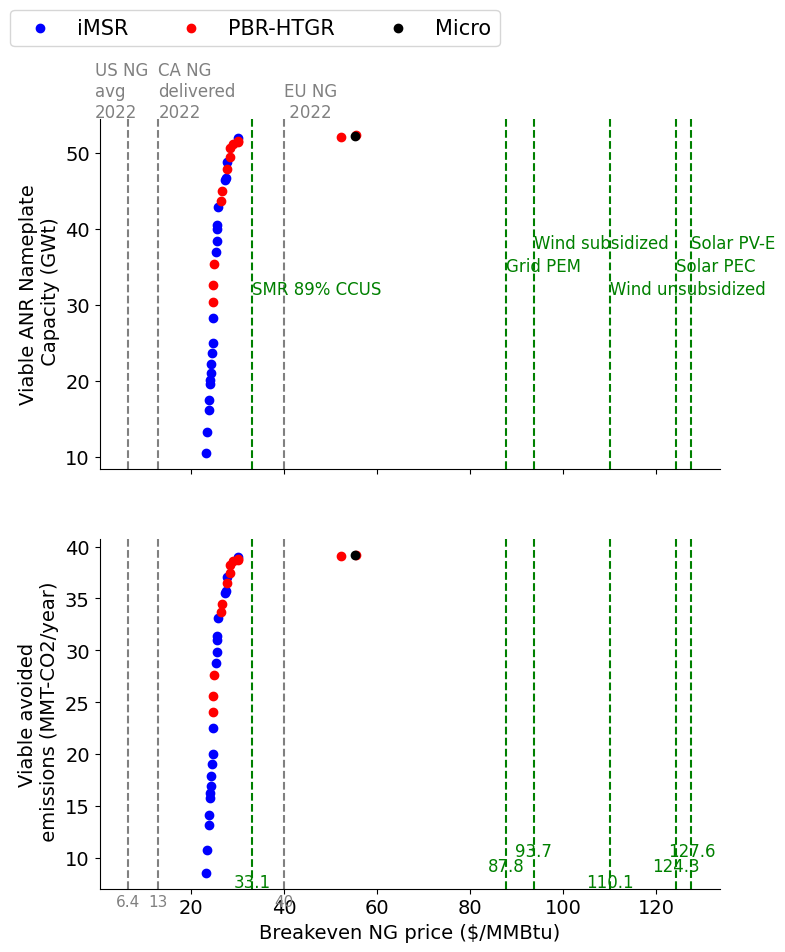

In [19]:
#Use latex font
#plt.rcParams['text.usetex'] = True
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['font.size'] = 14

# Create subplots
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 10))

# Get unique ANR types and assign colors
anr_types = df['ANR type'].unique()

colors = ['blue', 'red', 'black']  # Adjust the colors according to the unique ANR types
# Initialize empty handles for legend
handles = []
# Plotting the data as scatter plots with different colors for each ANR type
labels = {'ANR Nameplate Capacity (GWt)': 'Viable ANR Nameplate\n Capacity (GWt)',
            'Viable avoided emissions (MMT-CO2/year)': 'Viable avoided\n emissions (MMT-CO2/year)'}
for i, col in enumerate(['ANR Nameplate Capacity (GWt)', 'Viable avoided emissions (MMT-CO2/year)']):
    for anr_type, color in zip(anr_types, colors):
        subset = df[df['ANR type'] == anr_type]
        axs[i].scatter(subset['Breakeven NG price ($/MMBtu)'], subset[col], color=color, label=f'{anr_type}')
    axs[i].set_ylabel(labels[col])

    # Remove the top and right spines
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)


    # Adding vertical lines
    res_be = pd.read_csv('./results/res_be_ammonia.csv')
    res_be.sort_values(by='Breakeven price ($/MMBtu)', inplace=True)
    res_be['Breakeven price ($/MMBtu)'] = res_be.apply(lambda x:np.round(x['Breakeven price ($/MMBtu)'],1), axis=1)

    ng_vertical_lines = [6.4, 13, 40]
    ng_labels = ['US NG\navg 2022', 'CA NG\ndelivered 2022', 'EU NG\n 2022']
    res_vert_lines = list(res_be['Breakeven price ($/MMBtu)'])
    for line in ng_vertical_lines:
        axs[i].axvline(x=line, linestyle='--', color='grey')
    for l,line in enumerate(res_vert_lines):
        axs[i].axvline(x=line, linestyle='--',color='green')


ng_labels = ['US NG\navg\n2022', 'CA NG\ndelivered\n2022', 'EU NG\n 2022']
count = 0
xoffset =0
for x, l in zip(ng_vertical_lines, ng_labels):
    if count==0:
      xoffset = -7
    else:
        xoffset=0
    axs[0].text(x+xoffset, axs[0].get_ylim()[1]+0.2, l, fontsize=12, color='grey')
    axs[1].text(x, axs[1].get_ylim()[0]-0.5, str(x), color='grey', fontsize=11, va='top', ha='center')
    count+=1

res_labels = res_be['RES']
count = 0
for x, label in zip(res_vert_lines, res_labels):
    axs[0].text(x, (axs[0].get_ylim()[1]+axs[0].get_ylim()[0])/2+3*np.mod(count,3), label, fontsize=12, color='green')
    axs[1].text(x, axs[1].get_ylim()[0]+1.5*np.mod(count,3)+1.5, str(x), color='green', fontsize=12, va='top',ha='center')
    count+=1


# Setting the title and labels
plt.xlabel('Breakeven NG price ($/MMBtu)')


# Add a common legend for all subplots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', ncol=len(anr_types))
#fig.tight_layout()
#plt.show()
plt.savefig(save_fig_path)